# Notebook 22: Chapter 6 Figures

This notebook performs a segmentation workflow adapted from NB 11.
The F50 sand experiment F63 is used to generate figures to be used in Chapter
6 of Gus's thesis.

# Import packages

In [1]:
# Standard library imports
from pathlib import Path
# Third-party imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi
from scipy import signal
from skimage import color, morphology
# Local module imports
from segmentflow import segment, view
# Enable autoreload packages for changes made to local modules
%load_ext autoreload
%autoreload 2

## Load 3D data

Passing `slice_crop`, `row_crop`, and `col_crop` to only load part of the dataset

Loading images...
--> Images loaded as 3D array:  (150, 150, 150)
Plotting images: [  0  74 149]


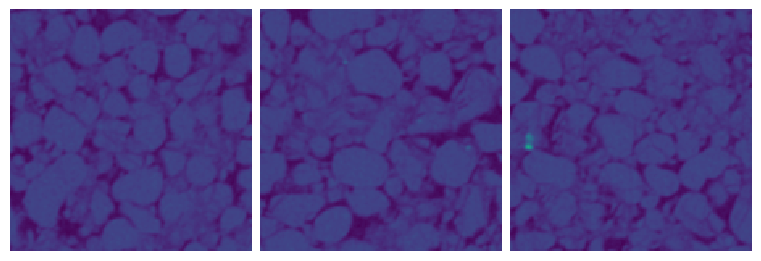

In [2]:
# Load images as 3D array from a directory containing images
imgs = segment.load_images(
    Path('../data/F63tiff/'),
    slice_crop=[400, 550],
    row_crop=[400, 550],
    col_crop=[400, 550],
    convert_to_float=True,
    file_suffix='tiff'
)
slices = np.linspace(0, 149, 3).astype(int)
fig, axes = view.plot_slices(imgs, slices=slices)

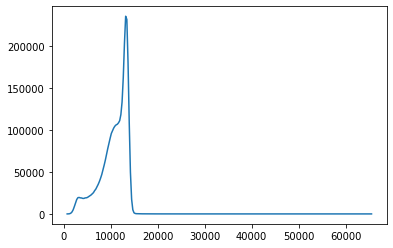

In [3]:
hist, bin_edges = np.histogram(imgs, bins=256)
fig, ax = plt.subplots()
ax.plot(bin_edges[1:], hist)
plt.show()

## Preprocess data

Preprocessing images...
--> Applying median filter...
--> Rescaling intensities to percentile range [0, 99.9]...
--> Preprocessing complete
Plotting images: [  0  74 149]


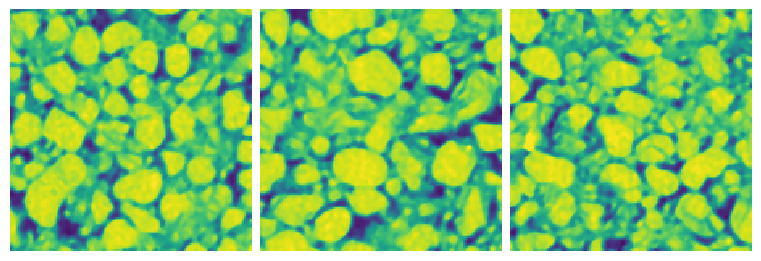

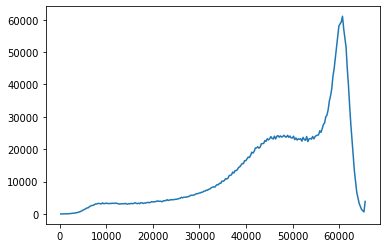

In [4]:
imgs_pre = segment.preprocess(
    imgs, median_filter=True, rescale_intensity_range=[0, 99.9]
)
fig, axes = view.plot_slices(imgs_pre, slices=slices)
hist, bin_edges = np.histogram(imgs_pre, bins=256)
fig, ax = plt.subplots()
ax.plot(bin_edges[1:], hist)
plt.show()

--> 3 peak(s) found: [11796.300000000001, 47840.55, 59636.85]
--> 2 min(s) found: [12451.65, 51117.3]


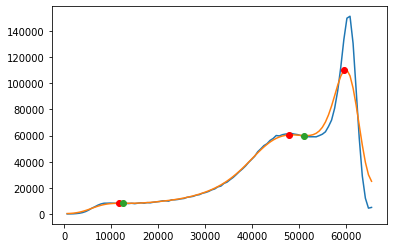

In [5]:
fig, ax = plt.subplots()
nbins = 100
# Calculate histogram
hist, bins = np.histogram(imgs_pre, bins=nbins)
ax.plot(bins[1:], hist)
# Smooth histogram with Gaussian filter
hist_smooth = ndi.gaussian_filter(hist, 3)
ax.plot(bins[1:], hist_smooth, c='C1')
# Find local maxima in smoothed histogram
peak_inds, peak_props = signal.find_peaks(hist_smooth)
peaks = [bins[i] for i in peak_inds]
print(f'--> {len(peaks)} peak(s) found: {peaks}')
for i, val in zip(peak_inds, peaks):
    ax.scatter(val, hist_smooth[i], color='red', zorder=2)
# Find minima between each neighboring pair of local maxima
min_inds = []
for i in range(1, len(peak_inds)):
    min_sub_i = np.argmin(hist_smooth[peak_inds[i - 1] : peak_inds[i]])
    min_inds.append(min_sub_i + peak_inds[i - 1])
mins = [bins[i] for i in min_inds]
print(f'--> {len(mins)} min(s) found: {mins}')
for i, val in zip(min_inds, mins):
    ax.scatter(val, hist_smooth[i], color='C2', zorder=2)
plt.show()

Plotting images: [  0  74 149]


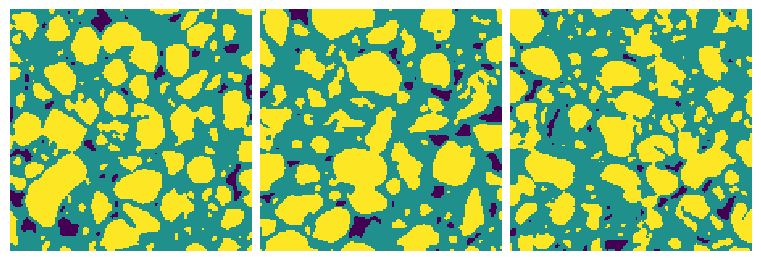

In [6]:
imgs_semantic = segment.isolate_classes(imgs_pre, [1.5e4, 5.3e4])
fig, axes = view.plot_slices(imgs_semantic, slices=slices)

Plotting images: [  0  74 149]


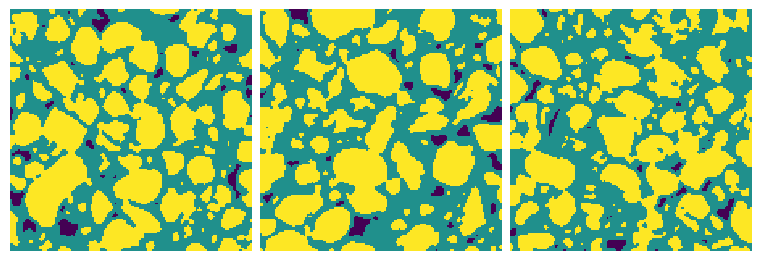

In [7]:
imgs_semantic = segment.isolate_classes(imgs_pre, mins)
fig, axes = view.plot_slices(imgs_semantic, slices=slices)

## Segment Data

Segmenting images...
--> Segmentation complete. 520 particle(s) segmented.


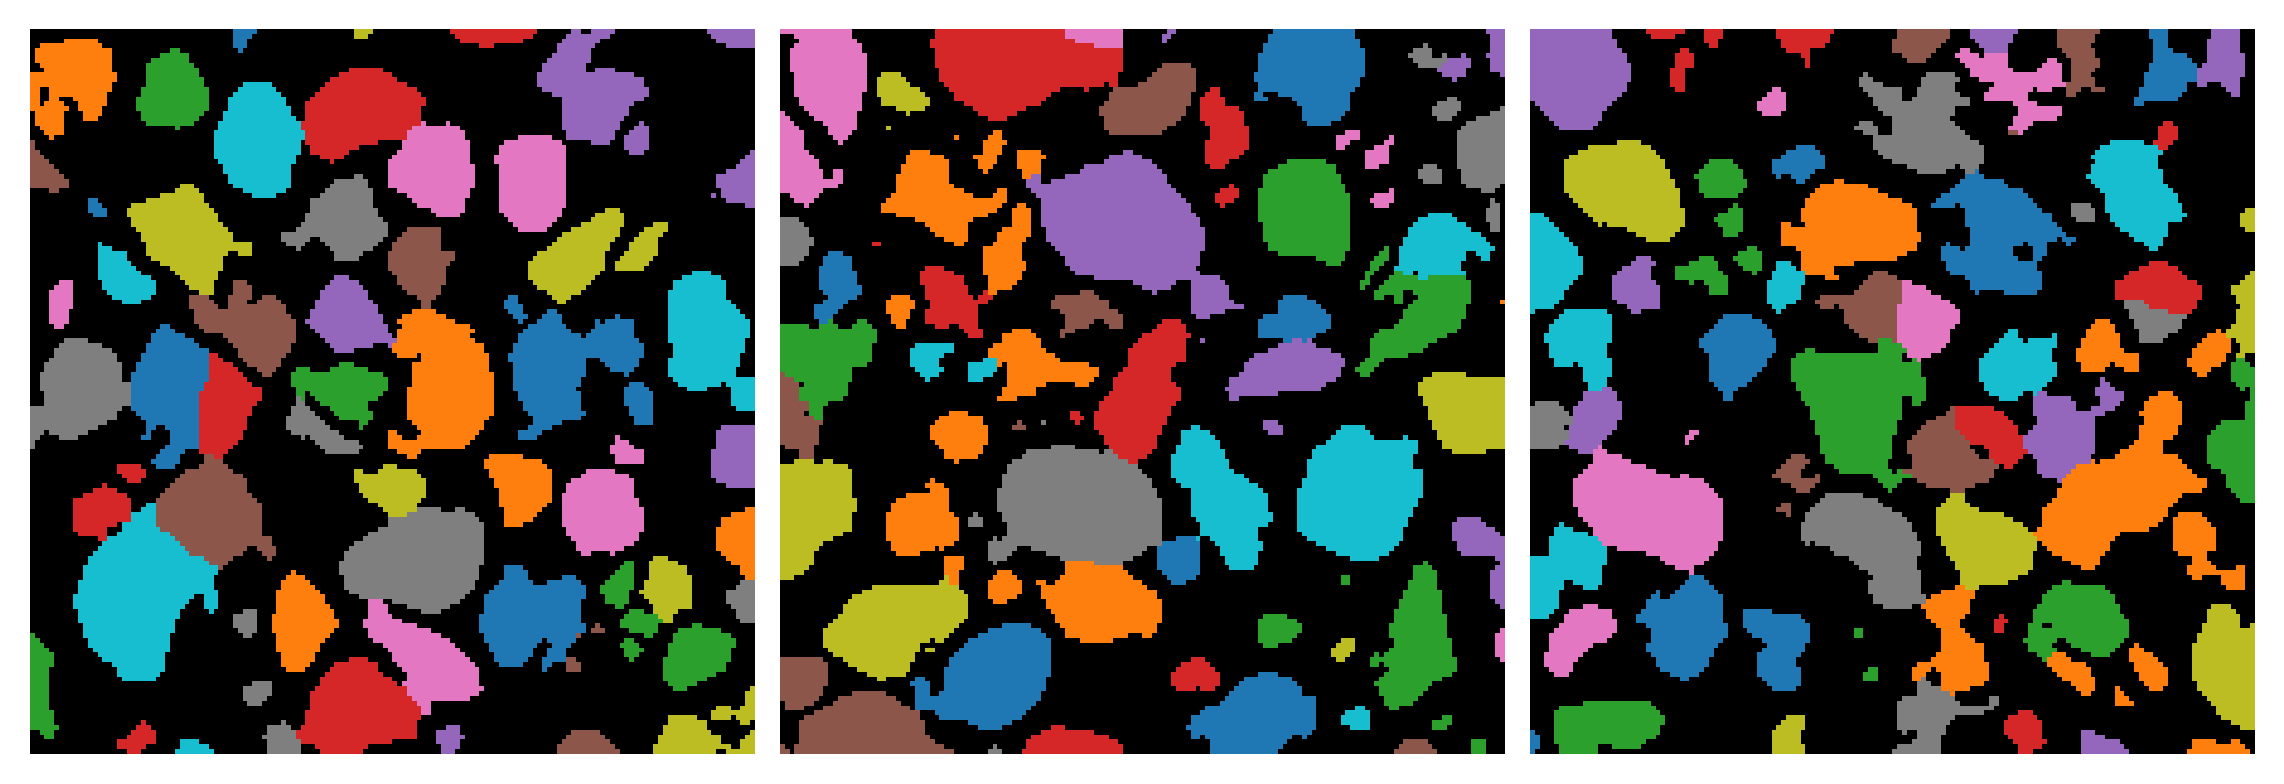

In [8]:
imgs_labeled = segment.watershed_segment(
    imgs_semantic == 2,
    min_peak_distance=7,
    return_dict=False
)
colors = view.get_colors(10, cmap=mpl.cm.tab10)
labeled_color = [
    color.label2rgb(imgs_labeled[i, ...], bg_label=0, colors=colors)
    for i in slices
]
fig, axes = view.plot_images(labeled_color, dpi=300)

Segmenting images...
--> Segmentation complete. 1236 particle(s) segmented.


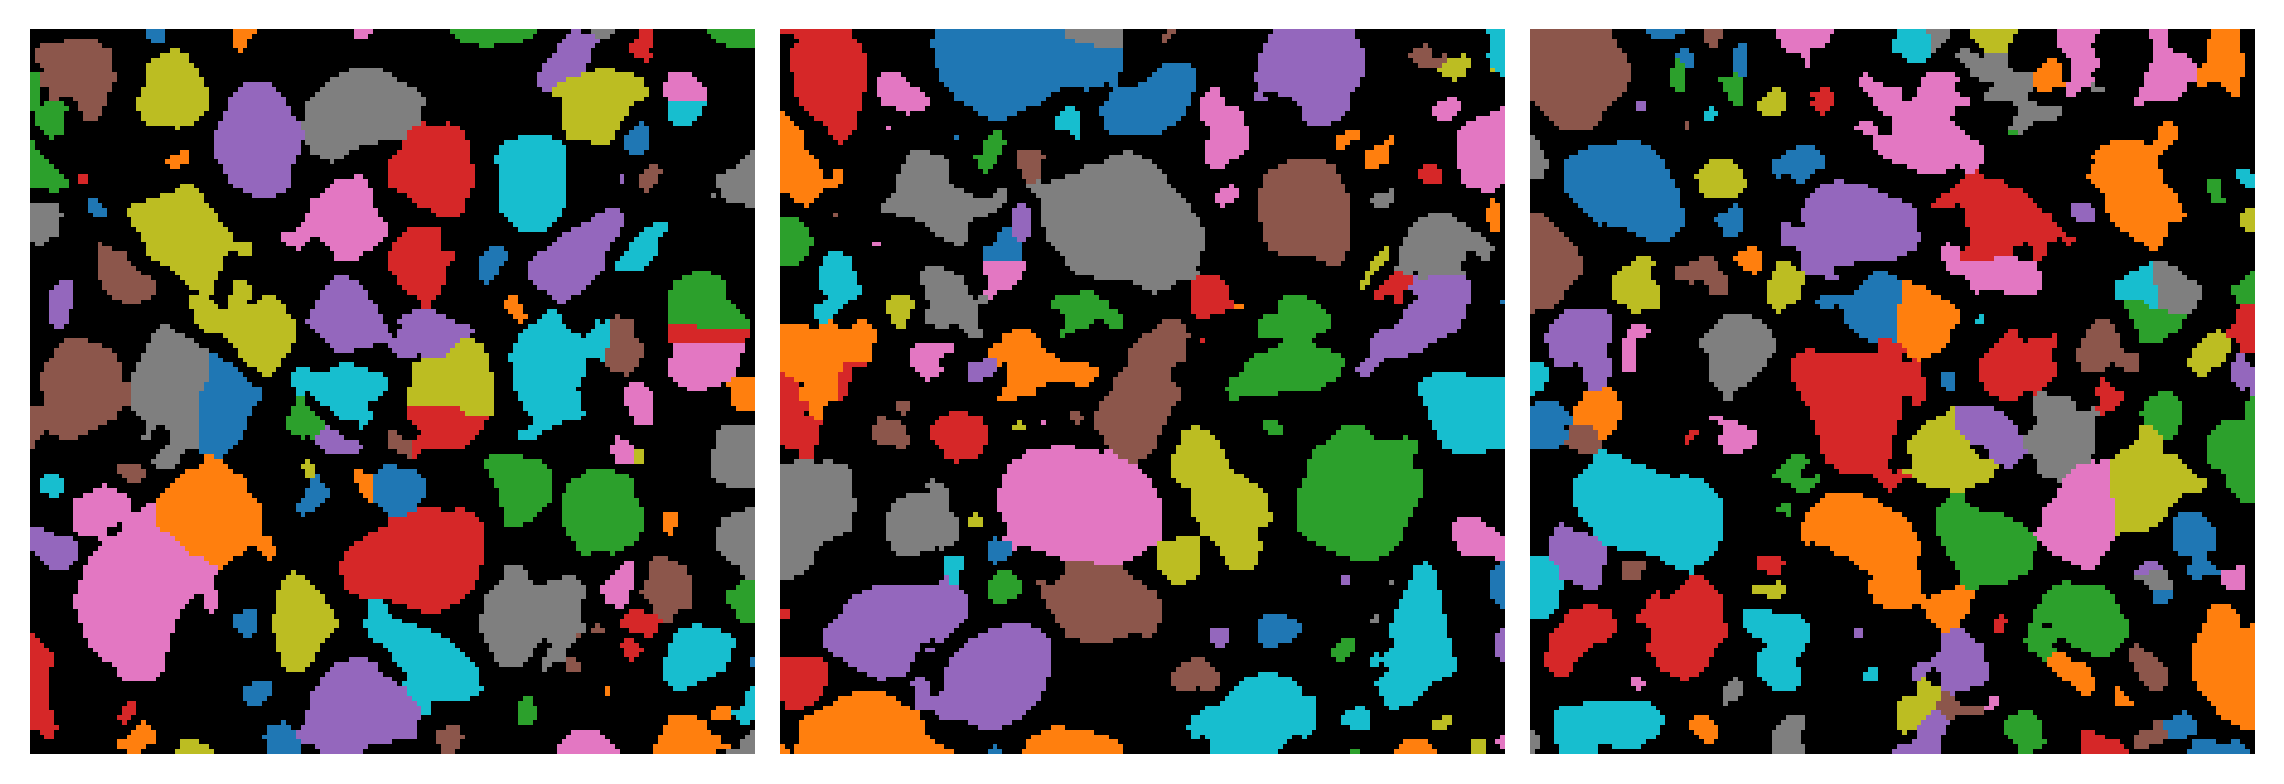

In [9]:
imgs_labeled = segment.watershed_segment(
    imgs_semantic == 2,
    min_peak_distance=4,
    return_dict=False
)
colors = view.get_colors(10, cmap=mpl.cm.tab10)
labeled_color = [
    color.label2rgb(imgs_labeled[i, ...], bg_label=0, colors=colors)
    for i in slices
]
fig, axes = view.plot_images( labeled_color, dpi=300)

Plotting images: [  0  74 149]


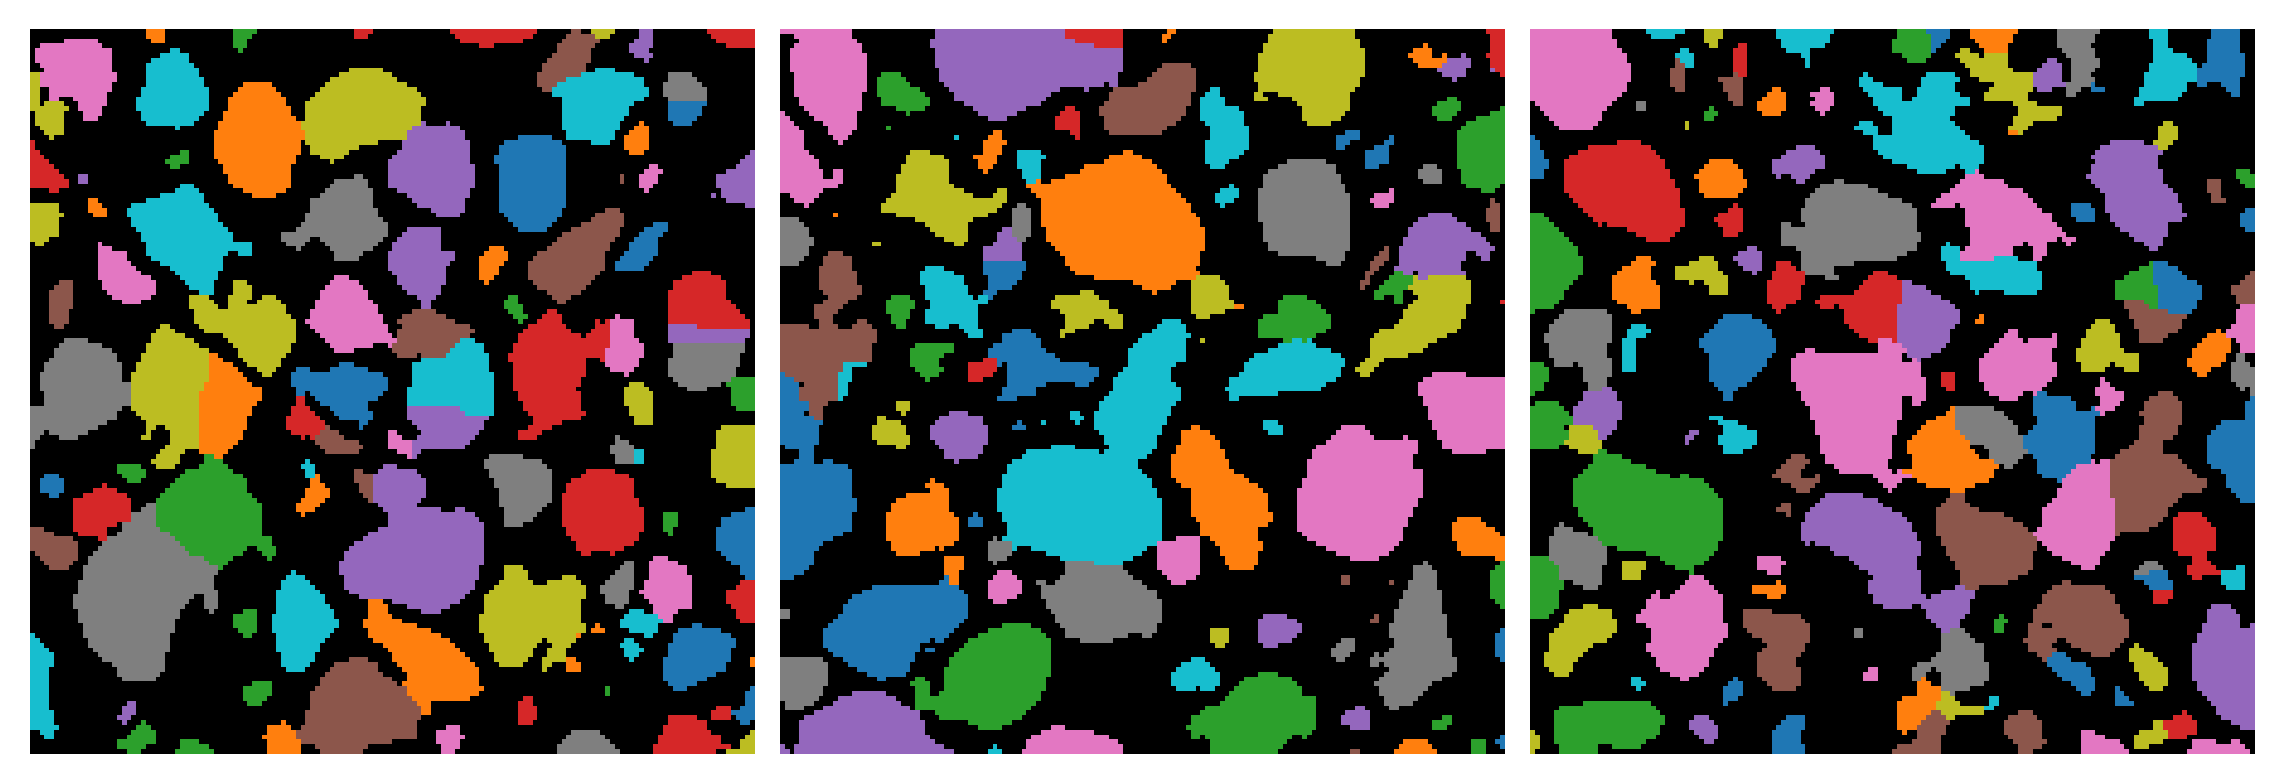

In [10]:
imgs_labeled_cyclic = np.zeros_like(imgs_labeled)
for i in range(1, imgs_labeled.max() + 1):
    imgs_labeled_cyclic[imgs_labeled == i] = i % 10 + 1
fig, axes = view.plot_slices(
    np.zeros_like(imgs_labeled_cyclic), slices=slices, cmap='gray', dpi=300)
imgs_labeled_cyclic = np.ma.masked_where(
    imgs_labeled_cyclic < 1, imgs_labeled_cyclic)
for i, ax in zip(slices, axes):
    ax.imshow(
        imgs_labeled_cyclic[i, ...], cmap=mpl.cm.tab10,
        interpolation='nearest')

From here, generate a set of STLs for different values for `min_peak_distance`,
perform a simulated sieve analysis on each dataset, and determine from there
which value achieves the closest calculated fit with the manufacturer's sieve
analysis.